In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [39]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [40]:
array_shape = (4,4)
telescope_number = np.prod(array_shape)
telescope_array = np.arange(telescope_number).reshape(array_shape)
tele_pos = [np.array(np.unravel_index(i, array_shape)) for i in range(telescope_number)]

In [41]:
def get_baseline_key(i1, i2, shape=array_shape):
    p1 = np.array(np.unravel_index(i1, shape))
    p2 = np.array(np.unravel_index(i2, shape))
    pos_diff = p1 - p2
    sign = np.product(pos_diff)
    if sign > 0:
        key = tuple(np.abs(pos_diff))
    else:
        key = tuple((np.abs(pos_diff[0]), -1*np.abs(pos_diff[1])))
    return key

In [42]:
def get_num_baselines(tele_num=telescope_number):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*tele_num - 2*np.sqrt(tele_num)
    return int(N_bases)

In [43]:
def get_baselines_np(tele_num=telescope_number):
    base_size = get_num_baselines(tele_num)
#     redundant_baselines = sparse.dok_matrix((base_size, tele_num, tele_num))
    redundant_baselines = np.zeros((base_size, tele_num, tele_num))
    baseline_indx = []
    for i in range(tele_num):
        for k in range(tele_num):
            if i==k:
                continue
            key = get_baseline_key(i,k)
            if key in baseline_indx:
                red_indx = baseline_indx.index(key)
                redundant_baselines[red_indx][i,k] = 1
            else:
                baseline_indx.append(key)
                redundant_baselines[len(baseline_indx)-1][i,k] = 1
    return redundant_baselines, baseline_indx

In [44]:
redundant_baselines, baseline_indx = get_baselines_np()
n_bases = get_num_baselines(telescope_number)

In [266]:
def get_baseline_indx(i1, i2, base_idx = baseline_indx):
    key = get_baseline_key(i1, i2)
    return base_idx.index(key)

In [45]:
rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)

In [46]:
npcb = np.vectorize(pow)

In [47]:
def make_gains(tele_num=telescope_number):
    gain_amp = np.abs(np.random.normal(1, .3, tele_num))
    gain_phase = rand_phases(tele_num)
    tgain = gain_amp*np.exp(1j*gain_phase)
    return tgain, gain_phase

In [48]:
def make_visibilities(tele_num=telescope_number):
    n_bases = get_num_baselines(telescope_number)
    sky_phase = rand_phases(n_bases)
    correl_sky = np.random.normal(3, .8, n_bases)*np.exp(1j*sky_phase)
    return correl_sky, sky_phase

In [212]:
def make_uv_points(tg, va, tele_num=telescope_number):
    observation_baselines = np.zeros((tele_num, tele_num), dtype=np.complex128)
    unsym_noise = np.random.normal(.01, .005, (tele_num, tele_num))*np.exp(1j*rand_phases((tele_num, tele_num)))
    noise_matrix = (unsym_noise + unsym_noise.T)*.5
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            key = get_baseline_key(i, k)
            red_indx = baseline_indx.index(key)
            if i < k:
                vaterm = va[red_indx]
            else:
                vaterm = np.conj(va[red_indx])
            sig = tg[i]*np.conj(tg[k])*vaterm
            noise = noise_matrix[i,k]
            observation_baselines[i,k] = sig+noise
    return observation_baselines, noise_matrix

In [213]:
tgain, gain_phase = make_gains()
valpha, v_phase = make_visibilities()

In [214]:
observation_baselines, noises = make_uv_points(tgain, valpha)

In [215]:
snr = np.mean(np.abs(valpha)/np.mean(np.abs(noises)))
print("SNR is %f" % snr)

SNR is 379.794262


In [253]:
gain_perturb = np.random.normal(.1,.02,telescope_number)*np.exp(1j*rand_phases(telescope_number))
va_perturb = np.random.normal(.4,.2,n_bases)*np.exp(1j*rand_phases(n_bases))

In [254]:
iter_max = 400
delta = .25
eps = 1e-5

# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
g0 = tgain
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha + va_perturb

garr = g0
varr = v0
y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
w_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)+16
ratio = np.zeros(iter_max)
score = np.zeros(iter_max)
chisqr = np.zeros(iter_max)

In [229]:
for n in tqdm(range(iter_max)):
    oldx = np.concatenate((garr, varr))
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            red_indx = get_baseline_indx(i,k)
            if i < k:
                vaterm = varr[red_indx]
            else:
                vaterm = np.conj(varr[red_indx])
                
            sig = garr[i]*np.conjugate(garr[k])*vaterm
            y_ij[i,k] = sig
#             w_ij[i,k] = (sig**2)
            w_ij[i,k] = 16
#     gprime = garr*npcb(((w_ij*observation_baselines)/y_ij).sum(axis=1)/(w_ij.sum(axis=1)), 1/3)
    gdiv = np.divide(w_ij*observation_baselines, y_ij, out=np.zeros_like(w_ij), where=(y_ij!=0))
    gprime = garr * npcb(gdiv.sum(axis=1)/(w_ij.sum(axis=1)), 2/3)
    garr = (1 - delta)*garr + delta*gprime
    
    vprime = np.zeros(n_bases, dtype=np.complex128)
    for i in range(n_bases):
        indxs = np.where(redundant_baselines[i]==1)
        numer = ((w_ij[indxs]*observation_baselines[indxs])/y_ij[indxs]).sum()
        denom = (w_ij[indxs]).sum()
        vprime[i] = varr[i]*npcb(numer/denom, 1/3)
    varr = (1-delta)*varr + delta*vprime
    
    gscale = 1/np.mean(np.abs(garr))
#     gscale = 1
    vscale = (1/gscale)**2
    garr = garr*gscale
    varr = varr*vscale
    
    newx = np.concatenate((garr, varr))
    delx = newx - oldx
    step_r = np.linalg.norm(delx)/np.linalg.norm(oldx)
    ratio[n] = step_r
    score[n] = np.linalg.norm(y_ij - observation_baselines)
    chisqr[n] = (np.abs(observation_baselines - y_ij)**2).sum()
    if n > 20:
        if (chisqr[n] - chisqr[n-1]) > 0:
            break
print(np.min(chisqr[chisqr.nonzero()]))


24.18251136649386


<ipython-input-230-54b012e986c4>:3: RuntimeWarning: divide by zero encountered in log10
  axes[0].plot(np.log10(ratio))


Text(0.5, 1.0, '$\\chi^2$')

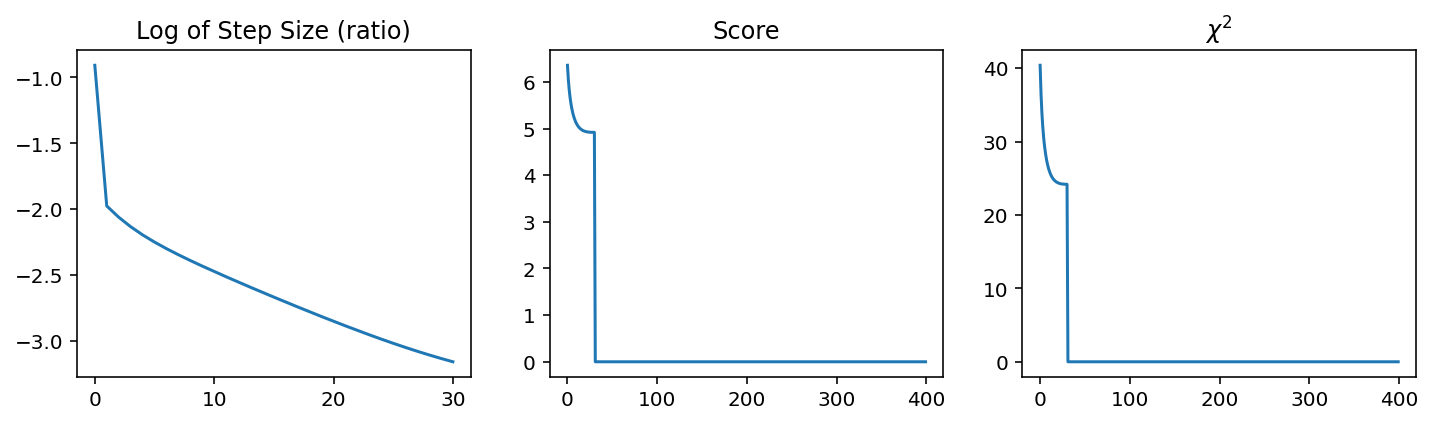

In [230]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

axes[0].plot(np.log10(ratio))
axes[0].set_title("Log of Step Size (ratio)")

axes[1].plot(score)
axes[1].set_title("Score")

axes[2].plot(chisqr)
axes[2].set_title(r"$\chi^2$")

In [231]:
gain_error = np.abs(tgain - garr)/np.abs(tgain)
v_error = (np.abs(valpha - varr)/np.abs(valpha))

In [232]:
print("Gain errors: ", gain_error)
print("Visibility errors: ", v_error)
print("Average errors: ", np.mean(gain_error), np.mean(v_error))

Gain errors:  [0.06482691 0.06451098 0.06931223 0.08449571 0.05547062 0.05932868
 0.0591581  0.06994391 0.06640643 0.06270086 0.05833947 0.06430492
 0.08845288 0.06467967 0.06549864 0.07131456]
Visibility errors:  [0.19982922 0.24116566 0.26796165 0.16011174 0.18540892 0.16311677
 0.15443815 0.20608991 0.20324495 0.14930653 0.14623877 0.28853183
 0.29759498 0.18286479 0.27648151 0.17926812 0.21213125 0.20304858
 0.16997676 0.18228076 0.18107961 0.17861779 0.19710281 0.1968593 ]
Average errors:  0.06679653536783081 0.20094793270746467


In [233]:
title_mod = r"Perturbed $V_\alpha$ and g ($\approx 3$)"

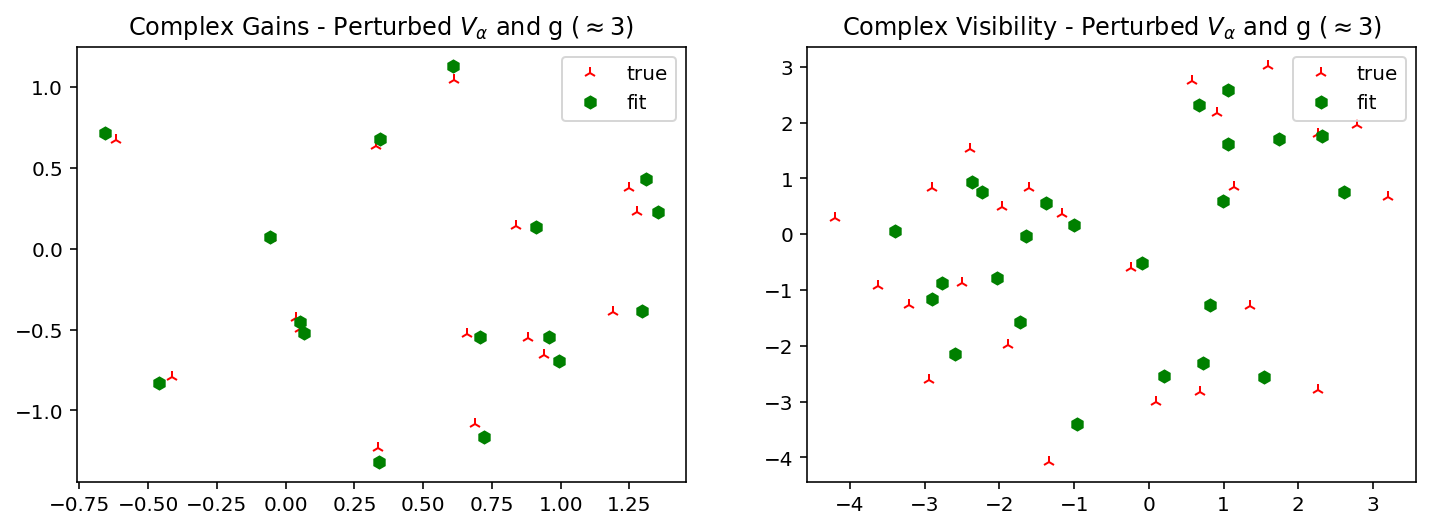

In [234]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

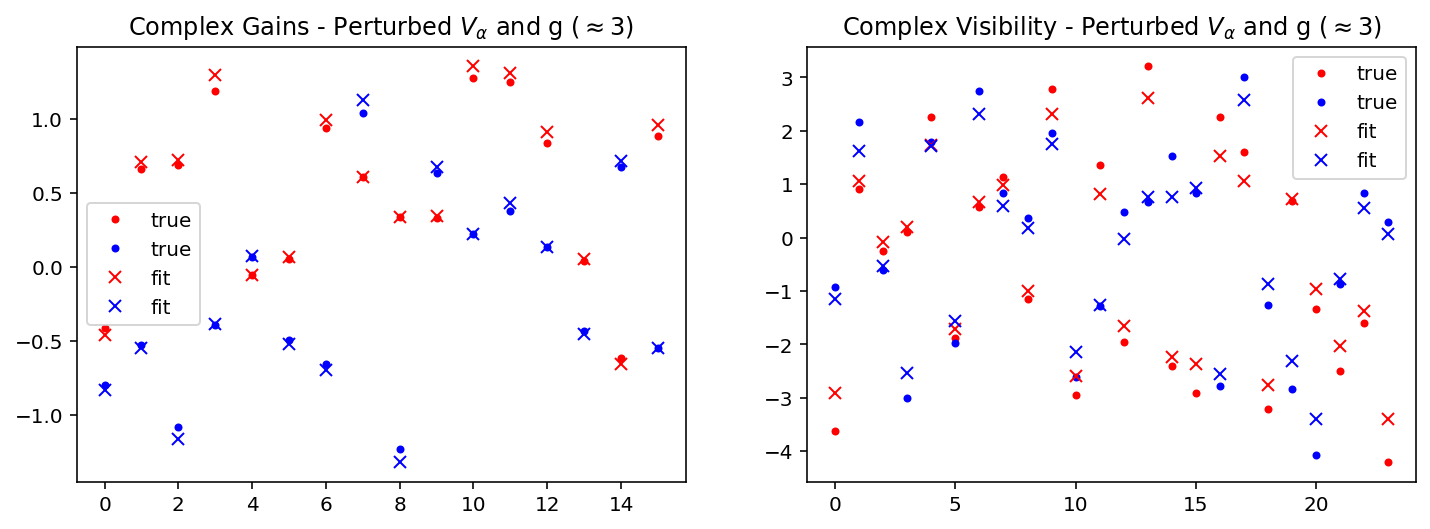

In [235]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, 'r.', label='true')
axes[0].plot(tgain.imag, 'b.', label='true')
axes[0].plot(garr.real, 'rx', label='fit')
axes[0].plot(garr.imag, 'bx', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, 'r.', label='true')
axes[1].plot(valpha.imag, 'b.', label='true')
axes[1].plot(varr.real, 'rx', label='fit')
axes[1].plot(varr.imag, 'bx', label='fit')
axes[1].legend();

In [236]:
telescope_array

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [427]:
iter_max = 10
delta = .25
eps = 1e-5

# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
g0 = tgain
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha

garr = g0
varr = v0
y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
w_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)+16
ratio = np.zeros(iter_max)
score = np.zeros(iter_max)
chisqr = np.zeros(iter_max)

In [419]:
for n in tqdm(range(40)):
    gprime = np.zeros(telescope_number, dtype=np.complex128)
    for i in range(telescope_number):
        numer = 0
        denom = 0
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                numer += garr[k]*np.conj(varr[v_indx])*observation_baselines[i,k]
                denom += (garr[k]*np.conj(varr[v_indx]))*np.conj((garr[k]*np.conj(varr[v_indx])))
        gprime[i] = numer/denom
    garr = gprime

In [403]:
for n in tqdm(range(400)):
    vprime = np.zeros(n_bases, dtype=np.complex128)
    for i in range(n_bases):
        indxs = np.where(redundant_baselines[i]==1)
        numer = (observation_baselines[indxs]).sum()
        denom = (garr[indxs[0]]*np.conj(garr[indxs[1]])).sum()
        vprime[i] = numer/denom
    varr = vprime

In [428]:
for n in tqdm(range(iter_max)):
    vprime = np.zeros(n_bases, dtype=np.complex128)
    for i in range(n_bases):
        indxs = np.where(redundant_baselines[i]==1)
        numer = (observation_baselines[indxs]).sum()
        denom = (garr[indxs[0]]*np.conj(garr[indxs[1]])).sum()
        vprime[i] = numer/denom
        
    gprime = np.zeros(telescope_number, dtype=np.complex128)
    for i in range(telescope_number):
        numer = 0+0j
        denom = 0+0j
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                numer += garr[k]*np.conj(varr[v_indx])*observation_baselines[i,k]
                denom += (garr[k]*np.conj(varr[v_indx]))*np.conj((garr[k]*np.conj(varr[v_indx])))
        gprime[i] = numer/denom
    garr = gprime
    varr = vprime
    gscale = 1/np.mean(np.abs(garr))
#     gscale = 1
    vscale = (1/gscale)**2
    garr = garr*gscale
    varr = varr*vscale

In [434]:
np.abs(garr) - np.abs(tgain)

array([ 0.04119617, -0.5883437 , -0.81313777, -1.19277691,  0.04657275,
       -0.47024887,  2.02982289,  0.875426  ,  0.56122428,  0.13077828,
       -0.35761096,  1.18317991, -0.83315373, -0.37825269,  0.07945744,
        0.64701084])

In [432]:
tgain

array([-0.41351696-0.79571621j,  0.65891262-0.52486249j,
        0.68770651-1.08301351j,  1.19026385-0.39379968j,
       -0.05468678+0.06871342j,  0.05240067-0.49703156j,
        0.93953601-0.65458326j,  0.61037142+1.04133756j,
        0.33469184-1.23267334j,  0.32995205+0.63218707j,
        1.27815331+0.22406689j,  1.2492849 +0.37594421j,
        0.83716456+0.13698062j,  0.03900529-0.43052246j,
       -0.61531687+0.67133804j,  0.88176332-0.55035294j])